In [1]:
# Importing necessary libraries
from matplotlib import legend
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
import numpy as np
from icecream import ic
from tqdm import tqdm
from itertools import chain
from get_data import get_data
import logging
import os

In [6]:
 #Define the LSTM model with two hidden layers
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
class LSTMmodel(nn.Module):
    """
    LSTM model class for derivative estimation.
    """

    def __init__(self, input_size, hidden_size, out_size, layers):
        """
        Initialize the LSTM model.

        Args:
        - input_size: Size of input
        - hidden_size: Size of hidden layer
        - out_size: Size of output
        - layers: Number of layers
        """
        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers, batch_first=True)

        # Define linear layer
        self.linear = nn.Linear(hidden_size, out_size)

    def forward(self, seq):
        """
        Forward pass through the LSTM model.

        Args:
        - seq: Input sequence

        Returns:
        - pred: Model prediction
        - hidden: Hidden state
        """
        lstm_out, hidden = self.lstm(seq)
        pred = self.linear(lstm_out)

        return pred, hidden


def slice_batch(batch, window_size=1):
    """
    Slice the input data into batches for training.

    Args:
    - batch: Input data batch
    - window_size: Size of the sliding window

    Returns:
    - List of sliced batches
    """
    l = []
    for i in range(len(batch) - window_size):
        l.append((batch[i:i+window_size, :], batch[i+1:i+window_size+1, 1:]))
    return l



cuda:0


In [2]:

def train(input_data, model, ws=1):
    """
    Train the LSTM model using input data.

    Args:
    - input_data: Input data for training
    - model: LSTM model to be trained
    - ws: Window size
    - odestep: Option for using ODE steps
    - use_autograd: Option for using autograd

    Returns:
    - Mean loss over all batches
    """
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    model.train()

    total_loss = []

    for batch in input_data:

        input = slice_batch(batch, ws)
        batch_loss = 0

        for inp, label in input:  # inp = (u, x) label = x

            output, _ = model(inp)

            #reconsider this part :
            #maybe | out = inp[-1, 1:] + output[-1] | works better
            #out = inp[:, 1:] + output
            out = inp[-1, 1:] + output[-1]

            optimizer.zero_grad(set_to_none=True)
            loss = loss_fn(out, label[-1])
            loss.backward()
            optimizer.step()

            batch_loss += loss.detach().cpu().numpy()

        total_loss.append(batch_loss/len(batch))

    return np.mean(total_loss)

In [3]:

def test(test_data, model, steps=600, ws=10):

    model.eval()
    loss_fn = nn.MSELoss()
    test_loss = 0
    test_loss_deriv = 0

    for i, x in enumerate(test_data):
        
        if i > 3:
            break

        with torch.inference_mode():

            pred = torch.zeros((steps, 3), device=device)
            pred_next_step = torch.zeros((steps, 3), device=device)

            if ws > 1:
                pred[0:ws, :] = x[0:ws, :]
                pred[:, 0] = x[:, 0]
                pred_next_step[0:ws, :] = x[0:ws, :]
                pred_next_step[:, 0] = x[:, 0]
            else:
                pred[0, :] = x[0, :]
                pred[:, 0] = x[:, 0]
                pred_next_step[0, :] = x[0, :]
                pred_next_step[:, 0] = x[:, 0]

            for i in range(len(x) - ws):
                out, _ = model(pred[i:i+ws, :])

                pred[i+ws, 1:] = pred[i+ws-1, 1:] + out[-1, :]
                pred_next_step[i+ws, 1:] = x[i+ws-1, 1:] + out[-1, :]
            
            test_loss += loss_fn(pred[:, 1], x[:, 1]).detach().cpu().numpy()
            test_loss_deriv += loss_fn(pred[:, 2], x[:, 2]).detach().cpu().numpy()

            figure , axs = plt.subplots(1,3,figsize=(16,9))
            
            axs[0].plot(np.linspace(0,1,steps), pred.detach().cpu().numpy()[:, 1], color="red", label="pred")
            axs[0].plot(np.linspace(0,1,steps), pred_next_step.detach().cpu().numpy()[:, 1], color="green", label="next step from data")
            axs[0].plot(np.linspace(0,1,steps), x.detach().cpu().numpy()[:, 1], color="blue", label="true", linestyle="dashed")

            axs[0].grid()
            axs[0].legend()

            axs[1].plot(np.linspace(0,1,steps), pred.detach().cpu().numpy()[
            :, 2], color="red", label="pred")
            axs[1].plot(np.linspace(0,1,steps), pred_next_step.detach().cpu().numpy()[:, 2], color="green", label="next step from data")
            axs[1].plot(np.linspace(0,1,steps), x.detach().cpu().numpy()[:, 2], color="blue", label="true", linestyle="dashed")

            axs[1].grid()
            axs[1].legend()
            axs[2].plot(np.linspace(0,1,steps), x.detach().cpu().numpy()[:,0], label="pressure")

            axs[2].grid()
            axs[2].legend()
            
    return np.mean(test_loss), np.mean(test_loss_deriv)


In [ ]:

def main():

    log_file = 'training.log'
    filemode = 'a' if os.path.exists(log_file) else 'w'

    # Configure logging
    logging.basicConfig(filename=log_file, filemode=filemode, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    # Define parameters
    window_size = 4

    losses = []
    device="cpu"
    # Generate input data
    input_data = get_data(path="save_data_test.csv")
    
    input_data = input_data.to(device)

    # Split data into train and test sets
    train_size = int(0.5 * len(input_data))
    test_size = len(input_data) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(input_data, [train_size, test_size])

    # Take a slice of data for training (only slice_of_data many timesteps)
    slice_of_data = 20

    train_dataset = train_dataset[:][:, 0:slice_of_data, :]

    # Initialize the LSTM model
    model = LSTMmodel(input_size=3, hidden_size=5, out_size=2, layers=1).to(device)

    trained=False
    if trained:
     path = f"Ventil_trained_NNs\lstm_ws{window_size}.pth"
     
     model.load_state_dict(torch.load(path, map_location=torch.device(device)))
    else:
        model = LSTMmodel(input_size=3, hidden_size=5, out_size=2, layers=1).to(device)
    
    #Train
    epochs = 100
    for e in tqdm(range(epochs)):
        loss_epoch = train(train_dataset, model, ws=window_size)
        losses.append(loss_epoch)
        if e % 2 == 0 or 1:
            print(f"Epoch {e}: Loss: {loss_epoch}")
   
    # Plot losses
    plt.plot(losses[1:])
    plt.show()

    # Save trained model
    path = f"Ventil_trained_NNs\lstm_ws{window_size}.pth"
    torch.save(model.state_dict(), path)

    #test the model

    a,b=test(test_dataset, model, steps=600, ws=10)
    print("s", a, "w", b)

    # Log parameters
    logging.info(f"Epochs: {epochs}, Window Size: {window_size}")
    logging.info(f"final loss {losses[-1]}")
    logging.info("--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    logging.info("--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    logging.info("\n")
    logging.info("\n")

    return None


if __name__ == "__main__":
    main()

# chat gpt instructions
# Add short and precise comments to the following python code. Describe functions, classes, loops similar things. The code:


In [4]:

def get_data(path = "ventil_lstm\save_data_test.csv"):
    
    df = pd.read_csv(path, header=0, nrows=600, skiprows=[x for x in range(1,100)])

    #drop even more timesteps
    df = df.iloc[::2]

    #Reorder columns for familiar setup (t,u,x) here (t, p_b, s_b, w_b)
    L = df.columns.to_list()
    time_cols = L[0::4]
    sb_cols = L[1::4]
    pb_cols = L[2::4]
    wb_cols = L[3::4]
    new_col_order = [x for sub in list(zip(time_cols, pb_cols, sb_cols, wb_cols)) for x in sub]
    df= df[new_col_order]
    df = df.drop(time_cols, axis=1)

    #normalise each column of the dataframe
    #mean normalization
    #df=(df-df.mean())/df.std()

    #min max normalization
    #normalize only a part of the data(??)
    df[sb_cols+wb_cols]=(df[sb_cols+wb_cols]-df[sb_cols+wb_cols].min())/(df[sb_cols+wb_cols].max()-df[sb_cols+wb_cols].min())
    
    #Can't normalize p_b because then a[i]*X+b[i] becomes cX+d for all i.. same with mean normal. 
    
    df[pb_cols] = df[pb_cols] / 1e5

    tensor = torch.tensor(df.values)

    #tensor with t=0:600, 500 different input and the 4 outputs [time, s_b, p_b, w_b]
    tensor = tensor.view(len(df),500,3).permute(1,0,2)


    return tensor

s 691.8486305042518 w 18317.596669572213


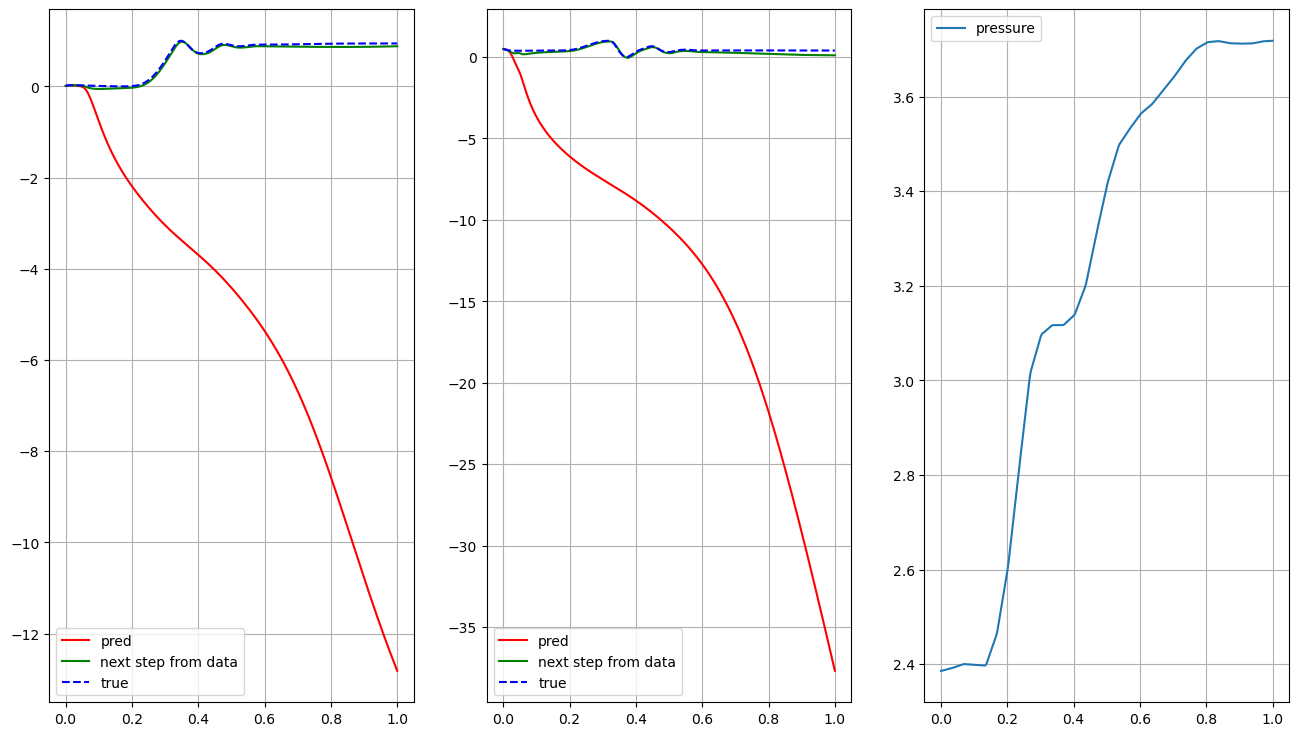

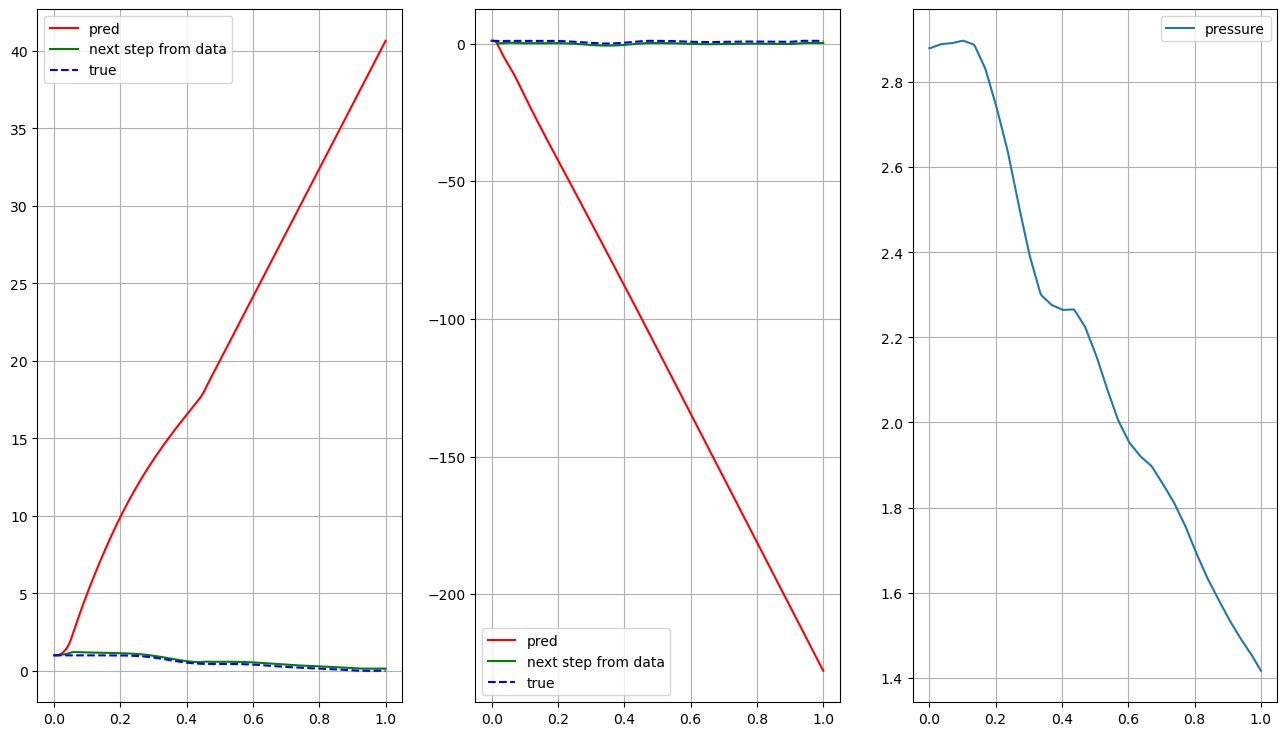

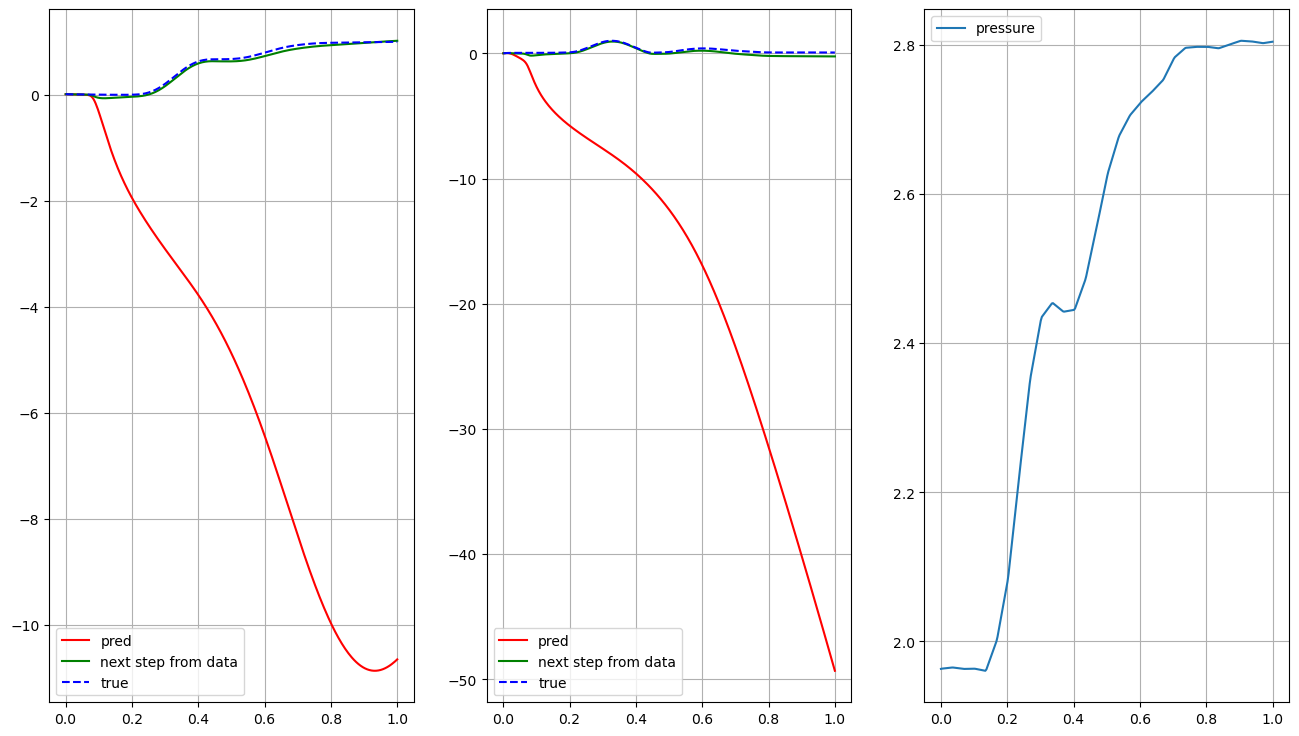

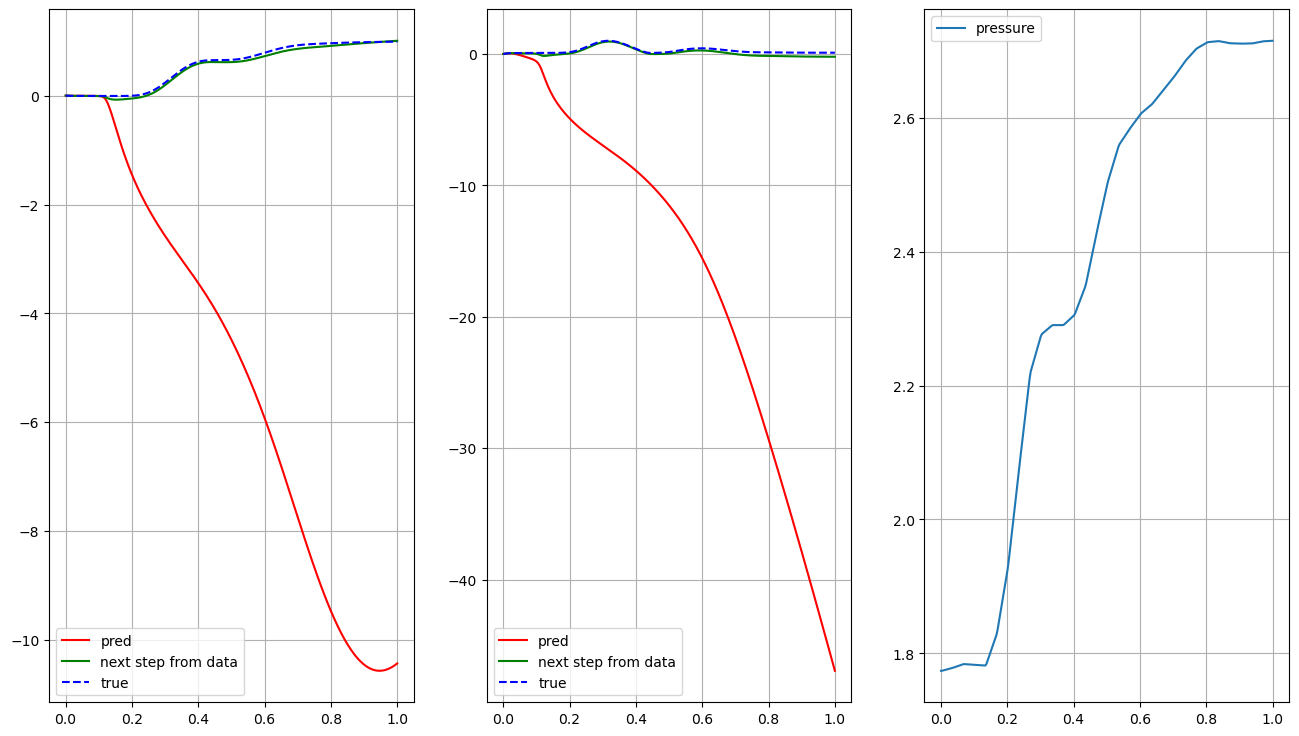

In [16]:
input_data = get_data(path="save_data_test.csv")
input_data=input_data.to(device)
# Split data into train and test sets
train_size = int(0.7 * len(input_data))
test_size = len(input_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(input_data, [train_size, test_size])

# Take a slice of data for training (only slice_of_data many timesteps)
slice_of_data = 300

train_dataset = train_dataset[:][:, 0:slice_of_data, :]

model = LSTMmodel(input_size=3, hidden_size=5, out_size=2, layers=1).to(device)

window_size =4
h_size=16
l_num=1
model = LSTMmodel(input_size=3, hidden_size=h_size, out_size=2, layers=l_num).to(device)

path = f"Ventil_trained_NNs\lstm_ws{window_size}hs{h_size}layer{l_num}.pth"

model.load_state_dict(torch.load(path, map_location=torch.device(device)))
a,b=test(train_dataset, model, steps=300, ws=window_size)
print("s", a, "w", b)

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

def get_data2(path):
    return torch.tensor([])


class CustomImageDataset(Dataset):
    def __init__(self, path="-", seq_len=1):
        self.data_tensor = get_data2(path) 
        self.seq_len = seq_len

    def __len__(self):
        return len(data_tensor)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
tensor = torch.randint(low=0, high=10, size=(3, 8, 3))
print(tensor)

ws=2

def get(id,tensor,ws):

    j = int(np.floor((id+ws) / tensor.size(1)))
    print("id", id, "j", j)
    if np.floor((id) / tensor.size(1))<np.floor((id+ws) / tensor.size(1)):

        off = id+(ws) - j*tensor.size(1)
        
        id = off 

        print(off, id+ws)

        inp = tensor[j,id:id+ws,:]
        label = tensor[j,id+ws,:]

        return inp, label
    
    else: 
        
        inp = tensor[j,id:id+ws,:]
        label = tensor[j,id+ws,:]

        return inp, label



for i in range(10):
    a, b  =get(i, tensor, 3)
    print(a)
   # print(b)